In [1]:
import tsnet
import numpy as np
import matplotlib.pyplot as plt
import wntr

In [2]:
# Open an example network and create a transient model
inp_file='../networks/net2.inp'
tm = tsnet.network.TransientModel(inp_file)
wn = wntr.network.WaterNetworkModel(inp_file)

In [3]:
tm.set_wavespeed(1000.) # m/s

# # Set time options
dt = 0.01
tf = 10   # simulation period [s]
tm.set_time(tf,dt)
#tm.set_time(tf)

Simulation time step 0.01000 s


In [4]:
# MOC 分段
MOC_n=tsnet.network.discretize.cal_N(tm,dt)
MOC_n[1]

array([5.])

In [5]:
# simulate valve close
ts = 0 # valve closure start time [s]
tc = 0 # valve closure period [s]
se = 0 # end open percentage [s]
m = 2 # closure constant [dimensionless] --> curve of Valve closure operating rule
pump_op = [tc,ts,se,m]
tm.pump_shut_off('Pump1', pump_op)

/home/sxli/anaconda3/envs/tf38/lib/python3.8/site-packages/tsnet/network/control.py:127: RuntimeWarning: invalid value encountered in double_scalars
  t = np.array([(i*dt- ts)/tc for i in range(tn)])
/home/sxli/anaconda3/envs/tf38/lib/python3.8/site-packages/tsnet/network/control.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  t = np.array([(i*dt- ts)/tc for i in range(tn)])


In [6]:
# Initialize steady state simulation
t0=0 # start time
tm = tsnet.simulation.Initializer(tm,t0,'DD')

Total Time Step in this simulation 1000


In [7]:
# Transient simulation
results_obj = 'demo2_pump_shut' # name of the object for saving simulation results
friction = 'unsteady' # "steady" or "unsteady" or "quasi-steady", by default "steady"
tm = tsnet.simulation.MOCSimulator(tm,results_obj,friction)

Initial condition discrepancy of pressure (-10.0000 m) on the J00000 node
Estimated simulation time 0:00:05.640000
Transient simulation completed 10 %...
Transient simulation completed 20 %...
Transient simulation completed 30 %...
Transient simulation completed 40 %...
Transient simulation completed 50 %...
Transient simulation completed 60 %...
Transient simulation completed 70 %...
Transient simulation completed 80 %...
Transient simulation completed 90 %...


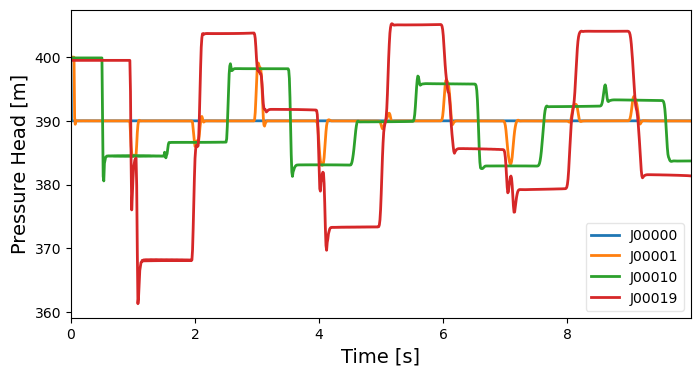

In [8]:
node = ['J00000','J00001','J00010','J00019']
tm.plot_node_head(node)

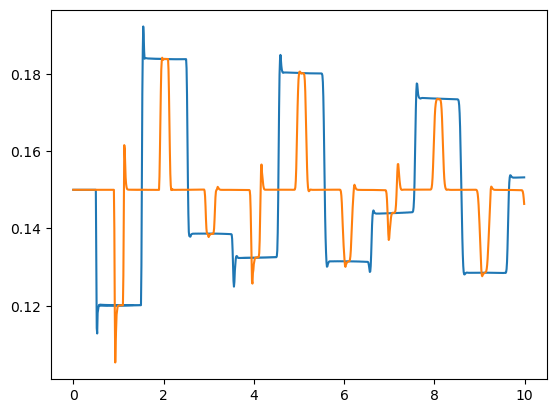

In [9]:
flow10=tm.get_link('P00010').start_node_flowrate

flow20=tm.get_link('P00018').start_node_flowrate
tt = tm.simulation_timestamps
plt.plot(tt,flow10)

plt.plot(tt,flow20)

# create the database

In [11]:
num_nodes=wn.num_nodes # col
row=len(tt)
flows=np.zeros([row,num_nodes])
heads=np.zeros([row,num_nodes])
flows.shape

(1000, 23)

In [12]:
# 00001-J00019-J00020 and R00001
i=0
for pipe_name, pipe in wn.pipes():
    flow_tmp=tm.get_link(pipe_name).start_node_flowrate
    print(i,pipe_name)
    flows[:,i]=flow_tmp

    if i==9:
        i+=1
        flows[:,i]=tm.get_link(pipe_name).end_node_flowrate
    
    if i==20:
        i+=1
        flows[:,i]=tm.get_link(pipe_name).end_node_flowrate
        # end node
    i+=1

0 P00000
1 P00001
2 P00002
3 P00003
4 P00004
5 P00005
6 P00006
7 P00007
8 P00008
9 P00009
11 P00010
12 P00011
13 P00012
14 P00013
15 P00014
16 P00015
17 P00016
18 P00017
19 P00018
20 P00019


In [13]:
flows

array([[0.5  , 0.5  , 0.5  , ..., 0.15 , 0.15 , 0.   ],
       [0.423, 0.5  , 0.5  , ..., 0.15 , 0.15 , 0.   ],
       [0.423, 0.5  , 0.5  , ..., 0.15 , 0.15 , 0.   ],
       ...,
       [0.45 , 0.45 , 0.453, ..., 0.15 , 0.15 , 0.   ],
       [0.45 , 0.45 , 0.456, ..., 0.15 , 0.15 , 0.   ],
       [0.45 , 0.45 , 0.461, ..., 0.15 , 0.15 , 0.   ]])

In [14]:
j=0
for node_name in wn.node_name_list:
    head_tmp=tm.get_node(node_name).head
    print(j,node_name)
    if j<num_nodes:
        heads[:,j]=head_tmp
    if j==10:
        j+=1
        heads[:,j]=head_tmp
    j+=1

0 J00000
1 J00001
2 J00002
3 J00003
4 J00004
5 J00005
6 J00006
7 J00007
8 J00008
9 J00009
10 J00010
12 J00011
13 J00012
14 J00013
15 J00014
16 J00015
17 J00016
18 J00017
19 J00018
20 J00019
21 J00020
22 J00021
23 R00001


In [15]:
heads

array([[400.   , 399.987, 399.973, ..., 399.485, 399.443,     nan],
       [390.   , 399.987, 399.973, ..., 399.485, 399.443,     nan],
       [390.   , 399.987, 399.973, ..., 399.485, 399.443,     nan],
       ...,
       [390.   , 389.983, 389.529, ..., 381.383, 381.343,     nan],
       [390.   , 389.979, 389.12 , ..., 381.379, 381.336,     nan],
       [390.   , 389.964, 388.531, ..., 381.36 , 381.334,     nan]])

In [16]:
# t-head ; t-flow
datah=np.zeros([row,num_nodes+1])
dataq=np.zeros([row,num_nodes+1])
datah[:,0]=np.asarray(tt)
dataq[:,0]=np.asarray(tt)
datah[:,1:]=heads
dataq[:,1:]=flows

In [17]:
# save to csv
np.savetxt('demo2_pump_h.csv',datah,fmt='%.4f',delimiter=',')
np.savetxt('demo2_pump_q.csv',dataq,fmt='%.4f',delimiter=',')